In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import statsmodels.api as sm
import matplotlib.dates as mdates
import numpy.matlib
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.model_selection import train_test_split
from dateutil.parser import parse
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
import matplotlib as mtlb
import math

In [59]:
pd.set_option('display.max_columns', 30)
df = pd.read_csv('weatherAUS.csv', index_col=0, parse_dates=True)


In [31]:
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
Date,,,,,,,,,,,,,,,,,,,,,,,
2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


# Preprocessing:Extract MaxTemp Data for Sydney



In [60]:
df=df[['Location','MaxTemp']]
df=df[df.Location=='Sydney']

In [61]:
df['Year'] = df.index.year
df['Quarter'] = df.index.quarter
df['Month'] = df.index.month
df['Weakday'] = df.index.weekday
df['Day'] = df.index.day

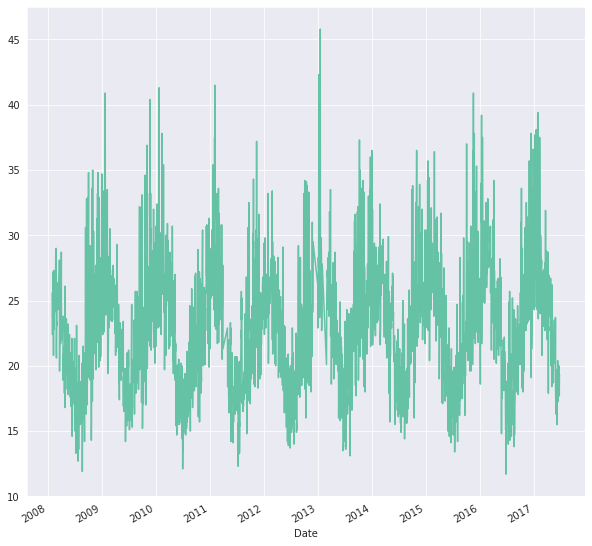

In [62]:
df['MaxTemp'].plot();
#df['Rainfall'].loc['2008-07':'2008-08'].plot()


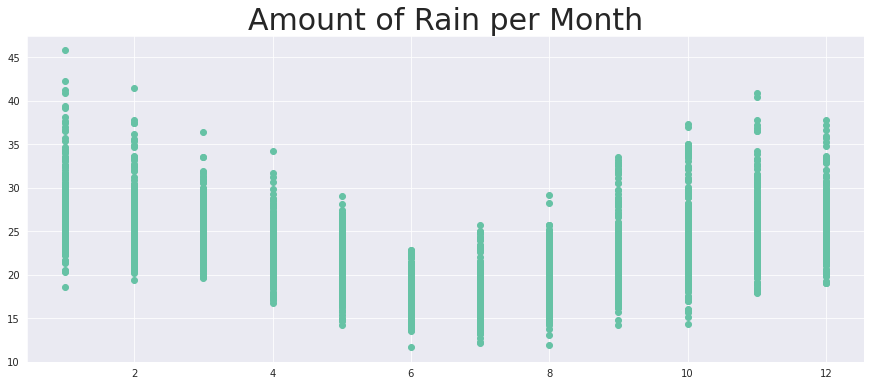

In [9]:
sns.set_style('darkgrid')
sns.set_palette('Set2')
plt.figure(figsize=[15,6])
plt.scatter(df['Month'], df['MaxTemp'])
plt.title( "Amount of Rain per Month",size = 30)
plt.show()

In [10]:
#Outliers
df[df.MaxTemp>45]

,Location,MaxTemp,Year,Quarter,Month,Weakday,Day
Date,,,,,,,
2013-01-18,Sydney,45.8,2013.0,1.0,1.0,4.0,18.0


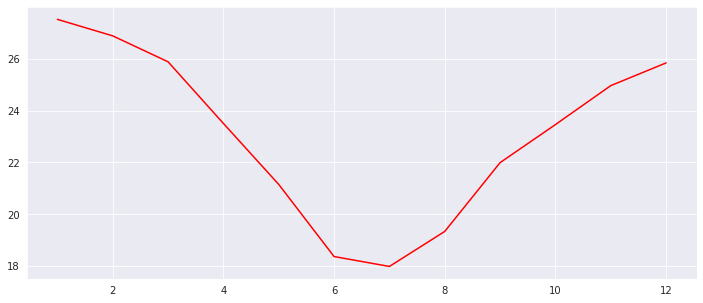

In [11]:
monthly_mean = df.groupby("Month").aggregate("mean")["MaxTemp"]
plt.figure(figsize=(12,5))
plt.plot(monthly_mean.index, monthly_mean, color='r')
plt.show()


In [12]:
monthly_mean

Month
1.0     27.517204
2.0     26.880784
3.0     25.881290
4.0     23.504444
5.0     21.153548
6.0     18.373129
7.0     17.991398
8.0     19.341935
9.0     21.994052
10.0    23.460650
11.0    24.962547
12.0    25.838211
Name: MaxTemp, dtype: float64

In [13]:
df.MaxTemp

Date
2008-02-01    22.4
2008-02-02    25.6
2008-02-03    24.5
2008-02-04    22.8
2008-02-05    25.7
              ... 
2017-06-21    19.6
2017-06-22    19.2
2017-06-23    17.7
2017-06-24    19.3
2017-06-25    19.3
Freq: D, Name: MaxTemp, Length: 3433, dtype: float64

# Deseasonalize Data

/home/hiob/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


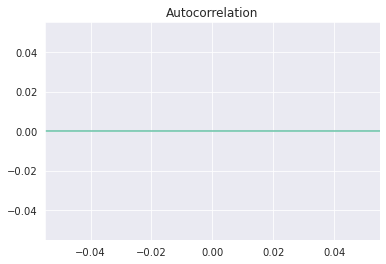

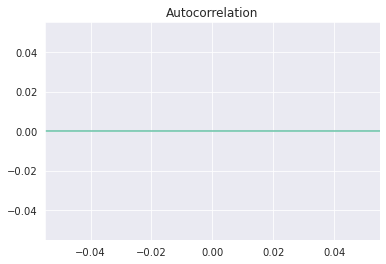

In [14]:
sm.graphics.tsa.plot_acf(df['MaxTemp'], lags=500)

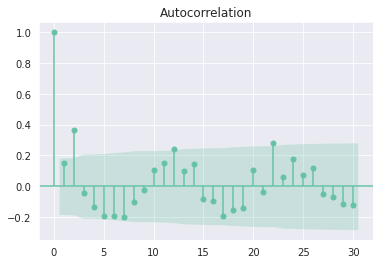

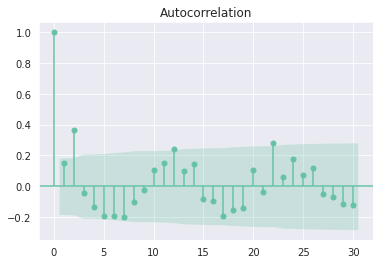

In [15]:
sm.graphics.tsa.plot_acf(df['MaxTemp'].resample('M').sum(), lags=30)

In [16]:
# df_des=df.copy()
# df_des=df_des.apply(lambda x: x.MaxTemp-monthly_mean[x.Month] , axis=1)
# sm.graphics.tsa.plot_acf(df_des.resample('M').sum(), lags=100)
#df_des.plot()

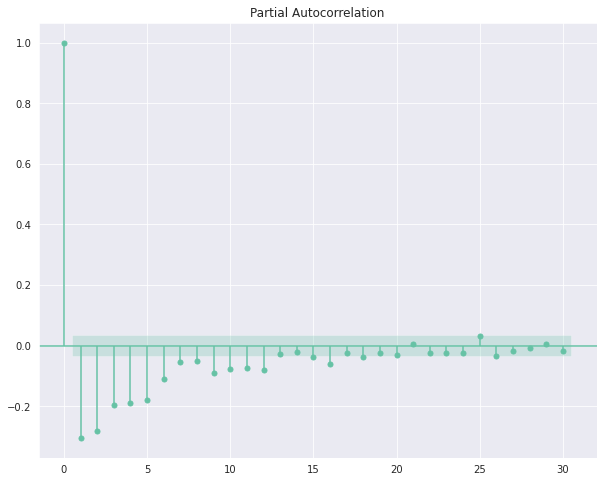

In [17]:
sns.set_style('darkgrid')
with mtlb.rc_context():
    mtlb.rc("figure", figsize=(10,8))
    sm.graphics.tsa.plot_pacf(df['MaxTemp'].diff().dropna(), lags=30)

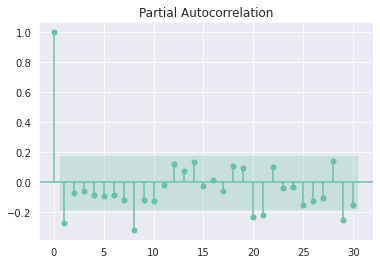

<Figure size 1080x432 with 0 Axes>

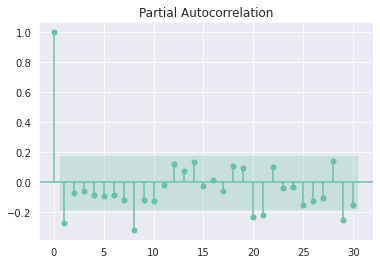

In [18]:
sns.set_style('darkgrid')
plt.figure(figsize=[15,6])
df_diff=df.copy()
df_diff=df['MaxTemp'].diff().dropna()
df_diff.isna().sum()
sm.graphics.tsa.plot_pacf(df_diff.resample('M').sum(), lags=30)


<AxesSubplot:xlabel='Date'>

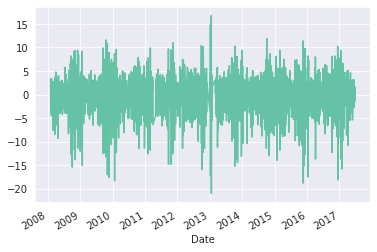

In [19]:
df_diff.plot()

#  ARIMA

In [64]:
df.dropna(subset=["MaxTemp"], inplace=True)


In [37]:
#check stationarity of time series
#but only checks long term trends not necesserally seasonality
result = adfuller(df['MaxTemp'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.138369
p-value: 0.000836


In [40]:
#df=df.asfreq('d')

In [70]:
# 6,1,2 ARIMA Model(p,d,q,s)
model = ARIMA(df['MaxTemp'], order=(6,1,2),enforce_stationarity=False)

model_fit = model.fit()

with model.fix_params({'ar.L1': 0}):
    model_fit = model.fit()

/home/hiob/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/hiob/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/hiob/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [71]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                MaxTemp   No. Observations:                 3335
Model:                 ARIMA(6, 1, 2)   Log Likelihood               -8367.693
Date:                Wed, 04 Aug 2021   AIC                          16751.386
Time:                        20:46:48   BIC                          16800.267
Sample:                             0   HQIC                         16768.876
                               - 3335                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1 (fixed)          0        nan        nan        nan         nan         nan
ar.L2             0.0202      0.024      0.826      0.409      -0.028       0.068
ar.L3            -0.0182      0.019     

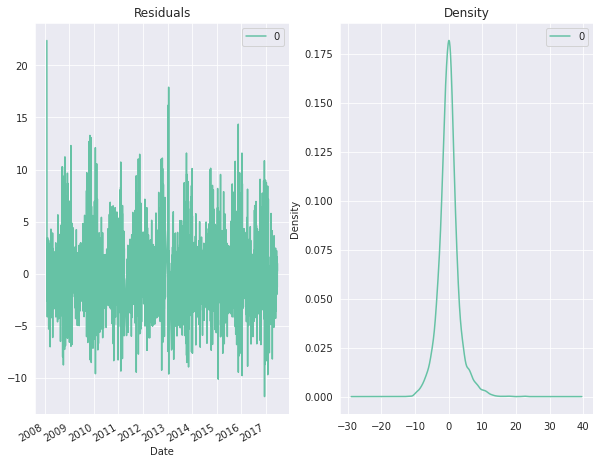

In [72]:
# Plot residual errors
sns.set_style('darkgrid')
with mtlb.rc_context():
    mtlb.rc("figure", figsize=(10,8))
    residuals = pd.DataFrame(model_fit.resid)
    fig, ax = plt.subplots(1,2)
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()

In [73]:
arima_preds=model_fit.fittedvalues
arima_preds[:2]=df['MaxTemp'][:2]

In [74]:
arima_preds.loc['2013-01-15':'2013-01-20']

Date
2013-01-15    25.789865
2013-01-16    26.312216
2013-01-17    27.281993
2013-01-18    27.890441
2013-01-19    34.460546
2013-01-20    25.819985
dtype: float64

In [75]:
df['MaxTemp'].loc['2013-01-15':'2013-01-20']

Date
2013-01-15    24.9
2013-01-16    27.2
2013-01-17    29.0
2013-01-18    45.8
2013-01-19    24.8
2013-01-20    24.3
Name: MaxTemp, dtype: float64

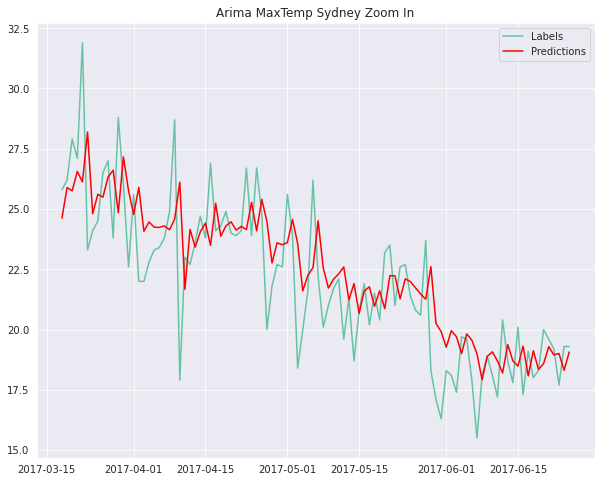

In [89]:
sns.set_style('darkgrid')
with mtlb.rc_context():
    mtlb.rc("figure", figsize=(10,8))
    plt.plot(df['MaxTemp'][-100:], label='Labels')
    plt.plot(arima_preds[-100:],color='red',label='Predictions');
    plt.title('Arima MaxTemp Sydney Zoom In');
    plt.legend()

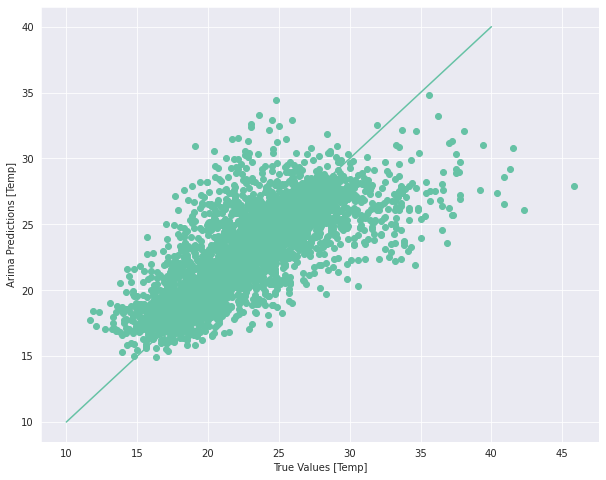

In [94]:
sns.set_style('darkgrid')
with mtlb.rc_context():
    mtlb.rc("figure", figsize=(10,8))
    plt.scatter(df.MaxTemp,arima_preds)
    plt.xlabel('True Values [Temp]')
    plt.ylabel('Arima Predictions [Temp]')

    plt.plot([10,40], [10,40]);

In [78]:
math.sqrt(mean_squared_error(df['MaxTemp'],arima_preds))

2.9880880031059096

In [ ]:
conf_int

In [ ]:
predictions=pd.Series(preds,index=test.index)
lower_conf = pd.Series(conf_int[:, 0], index=test.index)
upper_conf = pd.Series(conf_int[:, 1], index=test.index)


In [ ]:
plt.plot(train[-20:], label="Training")
plt.plot(test,label="Test")
plt.plot(predictions, label="Predicted")

# Plot
plt.fill_between(lower_conf.index, 
                 lower_conf, 
                 upper_conf, 
                 color='k', alpha=.15)
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)))

In [ ]:
model.plot_diagnostics()